In [9]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score,recall_score
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import warnings
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. compose import ColumnTransformer
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt  
from wordcloud import WordCloud

In [10]:
warnings.filterwarnings('ignore')

In [11]:
base_url = 'https://api.pushshift.io/reddit/search/'

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',200)

### Pulling in Posts from Reddit Pushshift API

In [13]:
def pull_posts(base_url,subreddit,length):
    data_pulls = pd.DataFrame()
    before = 1650821963
    for i in range(length):
        parameters = {'subreddit': subreddit,
                  'size': 100,
                  'is_self' : True,
                  'before': before}
        try:
            response = requests.get(base_url+'submission/',parameters)
            if response.status_code != 200:
                print('request failed')
            else:
                data = response.json()
                posts = data['data']
                posts = pd.DataFrame(posts)
                data_pulls = pd.concat([data_pulls,posts])
                time.sleep(5)
                before = data_pulls['created_utc'].iloc[-1]
        except:
            print("Exception: {}".format(type(exception).__name__))
            print("Exception message: {}".format(exception))
            time.sleep(15)
    return data_pulls

#futurology_pulls = pull_posts(base_url,'futurology',289)
#futurology_pulls.to_csv('./datasets/futurology_pull.csv',index=False)

#collapse_pulls = pull_posts(base_url,'collapse',288)
#collapse_pulls.to_csv('./datasets/collapse_pull.csv',index=False)

In [14]:
df_fut = pd.read_csv('datasets/futurology_pull.csv')
df_col = pd.read_csv('datasets/collapse_pull.csv')

In [15]:
len(df_col), len(df_fut)

(28741, 28876)

In [16]:
print(len(df_col[df_col['selftext'] == '[removed]']))
print(len(df_fut[df_fut['selftext'] == '[removed]']))

7323
11008


The significant amount of removed self-text for both subreddits led me to the analysis of submissions based on title alone.

### Checking for duplicates

In [17]:
df_fut = df_fut.drop_duplicates()
df_col = df_col.drop_duplicates()

### Dropping unnecessary columns

In [18]:
df_fut_cut = df_fut[['subreddit','title']]
df_col_cut = df_col[['subreddit','title']]

### Combining Dataframes

In [19]:
df_comb = pd.concat([df_col_cut,df_fut_cut])

In [20]:
df_comb.shape

(57617, 2)

### Shuffling and Splitting Dataset into Holdout

In [21]:
df_comb = df_comb.sample(frac=1,random_state=2)

In [22]:
df_holdout = df_comb[0:11523]
X_holdout = df_holdout['title']
y_holdout = df_holdout['subreddit']

In [23]:
df_main = df_comb[11523:]

In [24]:
df_holdout.shape, df_main.shape

((11523, 2), (46094, 2))

Using 30% of the dataset for initial analysis.

In [25]:
df_sample = df_main.sample(frac=0.3,random_state=2)

In [26]:
df_sample['subreddit'].value_counts(normalize=True)

Futurology    0.500434
collapse      0.499566
Name: subreddit, dtype: float64

In [27]:
df_sample['subreddit'].value_counts()

Futurology    6920
collapse      6908
Name: subreddit, dtype: int64

### TTS

In [28]:
X = df_sample['title']
y = df_sample['subreddit']

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2,stratify=y)

### Baseline Null

The below is our baseline score, against which the accuracy metrics of the model will be assessed. As this is the dataset's percentage of the majority class, the model will need to demonstrate the ability to choose the correct subreddit of origin at a higher rate than merely choosing 'Futurology' each time.

In [30]:
dc = DummyClassifier()
dc.fit(X_train,y_train)
dc.predict(X_test)
dc.score(X_test,y_test)

0.5004339022273647

### Tokenize/Lemmatize

In [31]:
def lemma_tokenizer(doc):
    wnl = WordNetLemmatizer()
    return [wnl.lemmatize(w) for w in word_tokenize(doc)]

### Creating Own List of Stopwords

Creating my own list of stopwords in an effort to cut through some of the noise the model may encounter from words that should ultimately not be important towards its classification of the posts. The words future/collapse, as well as the various forms the subreddits themselves may be referenced in the posts included in the stopwords so as not to give the model an advantage.

In [32]:
my_stop_words=['?',',','.','(',')',':','!','u','\'','i','are','that','the','on','and','is','to','a','of',\
               'in','what','for','will','you','it','be','this','with','do','n\'t','-','\'s','\'','an',\
               '`','.',',','u','/r/futurology','/r/collapse','~','e','g','’','``','=','o','de','r/collapse','r/futurology',\
               'we','how','about','have','can','if','all','or','would','by','our','why','not','your','year','when',\
               'could','there','like','from','...','an','ha','haha','hahaha','[]','[',']','so','new','now','doe',\
               'my','more','just','any','but','who','at','some','me',';','they','no','yes','out','should','get',\
               'most','s','than','up','one','wa','make','here','thing','#','$','got','&','*','where','anyone',\
               'futurology','future','\'''','%','🤔','🤙','😈','🔮','/r/futorology','“','😜','🗿','•',\
              '】해외베팅','】아시안커넥트/아시안커넥트 주소/아시안커넥트','】아시안커넥트/아시안커넥트','】스포츠토토','】메이저','【','》','《','☎1',\
              'collapsing','futurist','collapse',\
              'post-collapse','region','collapsed','link','in-depth',\
               'futuristic']

### Count Vectorize

In [33]:
cvec = CountVectorizer(strip_accents='unicode',stop_words=my_stop_words,ngram_range=(1,2),tokenizer=lemma_tokenizer)
cvec.fit(X_train)
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

X_train_cv = pd.DataFrame(X_train_cv.A,columns=cvec.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv.A,columns=cvec.get_feature_names_out())



### TF-IDF Vectorize

In [34]:
tfi = TfidfVectorizer(strip_accents='unicode',stop_words=my_stop_words,ngram_range=(1,2),tokenizer=lemma_tokenizer)
tfi.fit(X_train)
X_train_tfi = tfi.transform(X_train)
X_test_tfi = tfi.transform(X_test)

X_train_tfi = pd.DataFrame(X_train_tfi.A,columns=tfi.get_feature_names_out())
X_test_tfi = pd.DataFrame(X_test_tfi.A,columns=tfi.get_feature_names_out())

### Label Encoding Y

In [35]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [36]:
y_train_le.mean()

0.4995660977726352

Collapse = 1

The most commonly features in the vectorized model is reviewed in order to add words to the custom stopwords list.

### Reviewing Most Frequent Features

In [37]:
X_train_cv.sum().sort_values(ascending=False).head(25)

think             454
''                441
world             427
people            393
human             379
climate           353
change            333
technology        254
ai                253
going             227
climate change    218
time              199
life              191
next              187
need              178
thought           178
see               177
society           164
good              153
question          152
job               152
global            150
car               149
help              148
their             148
dtype: int64

### Naive Bayes

Running Multinomial Naive Bayes on lemmatized, countvectorized data. Model not shown dropped lemmatizer and model worsened.

In [99]:
pipenb = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer)),
    ('nb',MultinomialNB())   
    ])

pipenb.fit(X_train,y_train_le)
pipenb.score(X_train,y_train_le),pipenb.score(X_test,y_test_le)

(0.898177610645068, 0.798090830199595)

In [100]:
pipenb_params = {
    'cv__ngram_range' : [(1,1), (1,2), (2,2), (1,3), (2,3)],
    'cv__min_df': [1,2,3],
    'cv__max_df': [0.6,0.5,0.4],
}

In [102]:
gsnb = GridSearchCV(pipenb,param_grid=pipenb_params)
gsnb.fit(X_train,y_train_le)
gsnb.score(X_train,y_train_le),gsnb.score(X_test,y_test_le)

(0.9684697714781603, 0.8021405843216662)

In [103]:
gsnb.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.6, ngram_range=(1, 2),
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 strip_accents='unicode',
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('nb', MultinomialNB())])

The gridsearch yielded an improved model, with an accuracy score of 80.21%.

Scoring The TF-IDF vectorized data on Gaussian Naive Bayes. Multinomial Naive Bayes is suited for count-vectorized, Gaussian to data vectorized using TF-IDF.

In [108]:
gnb = GaussianNB()

gnb.fit(X_train_tfi,y_train_le)
gnb.score(X_train_tfi,y_train_le),gnb.score(X_test_tfi,y_test_le)

(0.9865008195930961, 0.6901938096615563)

The Gaussian Naive Bayes performs much worse than the Multinomial.

### Logistic, Count Vectorized

Running fairly basic Logistic Regression. CV data. Performs worse than Naive Bayes.

In [111]:
logregpipe = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

logregpipe.fit(X_train,y_train_le)
logregpipe.score(X_train,y_train_le),logregpipe.score(X_test,y_test_le)

(0.9300935300356764, 0.7839166907723459)

The model does not perform as well as Naive Bayes. Conducting gridsearch to tune hyperparamters.

In [114]:
logregpipe_params = {
    'cv__ngram_range' : [(1,1), (1,2), (2,2), (1,3), (2,3)],
    'cv__min_df': [1,2,3],
    'cv__max_df': [0.4,0.5,0.6],
    'lr__C': [.1,1,10,100]
}

In [115]:
gslogreg = GridSearchCV(logregpipe,param_grid=logregpipe_params)
gslogreg.fit(X_train,y_train)
gslogreg.score(X_train,y_train), gslogreg.score(X_test,y_test)

(0.9846687879664449, 0.7914376627133353)

In [116]:
gslogreg.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.4, ngram_range=(1, 2),
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 strip_accents='unicode',
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('lr', LogisticRegression(C=1, max_iter=10000))])

The gridsearch produces a model that tunes several paramters and produces an accuracy of 79.14%. Not as strong as Naive Bayes model.

In [129]:
logregpipe2 = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer,max_df=0.4,ngram_range=(1, 2),max_features=60000)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

logregpipe2.fit(X_train,y_train_le)
logregpipe2.score(X_train,y_train_le),logregpipe2.score(X_test,y_test_le)

(0.9835117153601388, 0.7885449811975701)

Efforts to improve score via implementing max features were unsuccessful.

### Logistic, TF-IDF

Running similar analysis, with TF-IDF vectorizing.

In [130]:
lgtpipe = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

lgtpipe.fit(X_train,y_train_le)
lgtpipe.score(X_train,y_train_le),lgtpipe.score(X_test,y_test_le)

(0.8961527335840324, 0.7943303442291004)

A fairly standard model performs better than the gridsearched count-vectorized model, with a 79.43% accuracy.

Building gridsearch to try to build better model.

In [134]:
lgtpipe_params = {
    'tf__min_df': [1, 2, 3,4],
    'tf__max_df': [.4, .5],
    'tf__ngram_range': [[1,1], [1,2], [2,2], [1,3]],
    'lr__C': [.1,1,10]
}

In [135]:
gslgt = GridSearchCV(lgtpipe,param_grid=lgtpipe_params)
gslgt.fit(X_train,y_train)
gslgt.score(X_train,y_train), gslgt.score(X_test,y_test)

(0.9595988814964805, 0.7931732716227944)

In [136]:
gslgt.best_estimator_

Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.4, ngram_range=[1, 3],
                                 stop_words=['?', ',', '.', '(', ')', ':', '!',
                                             'u', "'", 'i', 'are', 'that',
                                             'the', 'on', 'and', 'is', 'to',
                                             'a', 'of', 'in', 'what', 'for',
                                             'will', 'you', 'it', 'be', 'this',
                                             'with', 'do', "n't", ...],
                                 tokenizer=<function lemma_tokenizer at 0x7f82d49a2940>)),
                ('lr', LogisticRegression(C=1, max_iter=10000))])

In [150]:
lgtpipe2 = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,max_df=0.4,ngram_range=[1, 3],max_features=69000)),
    ('lr',LogisticRegression(max_iter=10000))   
    ])

lgtpipe2.fit(X_train,y_train_le)
lgtpipe2.score(X_train,y_train_le),lgtpipe2.score(X_test,y_test_le)

(0.9407964516440074, 0.795776684986983)

After running gridsearch, a better model is identified with a max feature parameter of 69,000. This is the best Logistic Regression model, but not as strong as the Naive Bayes.

### KNN Model

Running a KNN model with tuned parameters.

In [178]:
pipeknn = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=[1,3],max_df=0.5,min_df=3)),
    ('knc', KNeighborsClassifier(n_neighbors=3,weights='distance'))
    ])

pipeknn.fit(X_train,y_train_le)
pipeknn.score(X_train,y_train_le),pipeknn.score(X_test,y_test_le)

(0.9765692797223026, 0.6421752964998554)

The KNN model performs worse than any model previously seen in this analysis.

### Decision Tree Classifier

Running a Decision Tree Classifier with tuned parameters.

In [181]:
pipedtc = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=[1,3],max_df=0.5)),
    ('dtc', DecisionTreeClassifier(random_state=2,max_depth=10))
    ])

pipedtc.fit(X_train,y_train_le)
pipedtc.score(X_train,y_train_le),pipedtc.score(X_test,y_test_le)

(0.592710442580272, 0.5840323980329766)

This model performs worse than KNN.

### Random Forest, Count Vectorized

Running a Random Forest model with count vectorized data and tuned hyperparameters. 

In [205]:
piperfc = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,tokenizer=lemma_tokenizer,ngram_range=(1,2),max_df=0.5)),
    ('rfc', RandomForestClassifier(random_state=2,n_estimators=400,min_samples_split=4,max_depth=None))
    ])

piperfc.fit(X_train,y_train_le)
piperfc.score(X_train,y_train_le),piperfc.score(X_test,y_test_le)

(0.993732523382509, 0.7755279143766272)

Fairly strong, not as strong as Bayes or strongest logistic.

### Random Forest, TF-IDF Vectorized

Running  Random Forest model using the TF-IDF vectorization and tuned parameters.

In [210]:
piperfct = Pipeline(
    [
    ('tf',TfidfVectorizer(stop_words=my_stop_words,ngram_range=[1,2],max_df=0.5,tokenizer=lemma_tokenizer)),
    ('rfc', RandomForestClassifier(random_state=2,min_samples_split=5,n_estimators=400,max_depth=None))
    ])

piperfct.fit(X_train,y_train_le)
piperfct.score(X_train,y_train_le),piperfct.score(X_test,y_test_le)

(0.9945039051200463, 0.7639571883135666)

Model does not perform as strongly as the count vectorized model.

### Ada Booster

Running a tuned model using AdaBoost.

In [227]:
pipeada = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,ngram_range=[1,2],max_df=0.7,tokenizer=lemma_tokenizer,max_features=45000)),
    ('abc', AdaBoostClassifier(random_state=2,n_estimators=2000))
    ])

pipeada.fit(X_train,y_train_le)
pipeada.score(X_train,y_train_le),pipeada.score(X_test,y_test_le)

(0.9201619901648829, 0.7526757304020827)

Model does not perform as well as RFC, Bayes, or Logistic.

Running similar analysis with TF-IDF data.

In [225]:
pipeada = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,ngram_range=[1,1],max_df=0.7,tokenizer=lemma_tokenizer,max_features=45000)),
    ('abc', AdaBoostClassifier(random_state=2,n_estimators=2000))
    ])

pipeada.fit(X_train,y_train_le)
pipeada.score(X_train,y_train_le),pipeada.score(X_test,y_test_le)

(0.9493780734741105, 0.7243274515475846)

Model does not perform as well as with count vectorized data.

### Ensemble Analysis

Ensemble model built with Count Vectorized data, combining Logistic Regression, Multinomial Naive Bayes, and Random Forest Classifier.

In [31]:
vr1 = VotingClassifier(
    [('lr',LogisticRegression(max_iter=10000)),
     ('mnb', MultinomialNB()),
     ('rfc', RandomForestClassifier(random_state=2,min_samples_split=4,n_estimators=250)),
      ],
)

vr1.fit(X_train_cv,y_train_le)
vr1.score(X_train_cv,y_train_le),vr1.score(X_test_cv,y_test_le)

(0.9860187060071353, 0.7963552212901359)

This model was strong, but is slightly worse than the Naive Bayes Mode.

In [31]:
vr2 = VotingClassifier(
    [('lr',LogisticRegression(max_iter=10000)),
     ('mnb', MultinomialNB()),
     ('rfc', RandomForestClassifier(random_state=2,min_samples_split=4,n_estimators=250)),
      ],
)

vr2.fit(X_train_tfi,y_train_le)
vr2.score(X_train_tfi,y_train_le),vr2.score(X_test_tfi,y_test_le)

(0.9743515572268826, 0.8038761932311252)

Using TF-IFD vectorized data improves the model to 80.39% accuracy on the test set. This is the best model that has been produced thus far.

### Revisiting Naive Bayes

Running a tuned model of Multinomial Naive Bayes with Count Vectroized data, trigrams, and max features of 70,000.

In [37]:
pipenb2 = Pipeline(
    [
    ('cv',CountVectorizer(stop_words=my_stop_words,strip_accents='unicode',tokenizer=lemma_tokenizer,min_df=1,max_df=0.6,max_features=70000,ngram_range=(1,3))),
    ('nb',MultinomialNB())   
    ])

pipenb2.fit(X_train,y_train_le)
pipenb2.score(X_train,y_train_le),pipenb2.score(X_test,y_test_le)

(0.9662520489827403, 0.8278854498119756)

This is the best model that has yet been produced.

Running tuned model of Multinomial Naive Bayes, using TF-IDF, with bigrams and max features of 64,000.

In [38]:
pipenb3 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 2),max_df=.4,tokenizer=lemma_tokenizer,max_features=64000)),
    ('nb',MultinomialNB(alpha=1))   
    ])

pipenb3.fit(X_train,y_train_le)
pipenb3.score(X_train,y_train_le),pipenb3.score(X_test,y_test_le)

(0.9765692797223026, 0.8319352039340469)

This is the best model, with 83.19% accuracy on test set. This will be the model we proceed with.

### Further Analysis - Feature Importance and Adding StopWords

Identifying the features having the largest impact on the model.

In [40]:
imps = pipenb3.named_steps['nb'].feature_log_prob_[1,:] - pipenb3.named_steps['nb'].feature_log_prob_[0,:]

nb_feat_imp = pd.DataFrame(imps.T,
            index=pipenb3.named_steps['tfi'].get_feature_names_out().T,
            columns=['feature imps'])

#code help from: https://donernesto.github.io/blog/notes-on-multinomial-naive-bayes/

These are the 25 features strongest associated with the 'futurology' subreddit. From here, additional words referencing the future will be added to stop-words. This will hurt performance but create less biased model.

In [41]:
nb_feat_imp.sort_values(by='feature imps').head(25)

,feature imps
blockchain,-2.955593
ai,-2.911290
artificial,-2.747951
futurology,-2.529059
artificial intelligence,-2.444814
technology,-2.440723
machine,-2.369156
intelligence,-2.330655
immortality,-2.305131
automation,-2.249488


These are the 25 features strongest associated with the 'collapse' subreddit. From here, additional words referencing collapse will be added to stop-words. This will hurt performance but create less biased model.

In [42]:
nb_feat_imp.sort_values(by='feature imps').tail(25)

,feature imps
megathread,1.750478
climate,1.761892
winter,1.779387
think collapse,1.785148
survival,1.786198
collapse link,1.798374
during collapse,1.846681
collapse inevitable,1.865059
t,1.872692
protest,1.896588


### Rerunning model after Additional StopWords Added

Running best model with updated stopwords list.

In [38]:
pipenb4 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 2),max_df=.4,tokenizer=lemma_tokenizer,max_features=64000)),
    ('nb',MultinomialNB(alpha=1.2))   
    ])

pipenb4.fit(X_train,y_train_le)
pipenb4.score(X_train,y_train_le),pipenb4.score(X_test,y_test_le)

(0.966637739851509, 0.8067688747468904)

As expected, we see the performance fall to 80.67% accuracy on the test set.

The model would perform at 82.3% accuracy if the additional stopwords had not been aded.

### Running Model on Larger Dataset

Now running the model on the larger dataset, from which the 30% was extracted to perform the previous analysis above. Train/test split and label encoding done to facilitate this.

In [43]:
X2 = df_main['title']
y2 = df_main['subreddit']
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,random_state=2,stratify=y2)

y_train_le2 = le.fit_transform(y_train2)
y_test_le2 = le.transform(y_test2)

In [44]:
pipenb4.fit(X_train2,y_train_le2)
pipenb4.score(X_train2,y_train_le2),pipenb4.score(X_test2,y_test_le2)

(0.9047439976858548, 0.8282714335300243)

The performance on the largeer test dataset is to 82.8% accuracy. The model got better as it saw more data.

In [220]:
imps2 = pipenb4.named_steps['nb'].feature_log_prob_[1,:] - pipenb4.named_steps['nb'].feature_log_prob_[0,:]
nb_feat_imp2 = pd.DataFrame(imps2.T,
            index=pipenb4.named_steps['tfi'].get_feature_names_out().T,
            columns=['feature imps'])

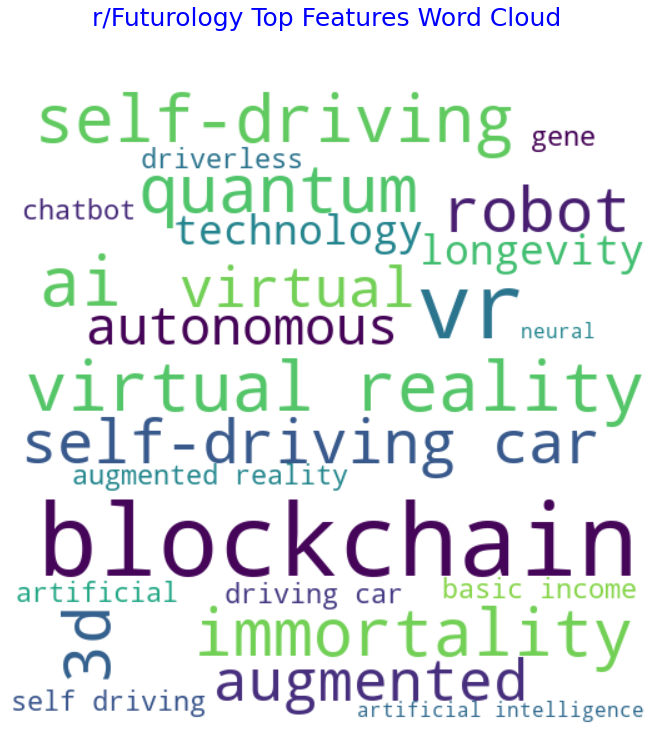

<Figure size 432x288 with 0 Axes>

In [221]:
fut_25 = nb_feat_imp2.sort_values(by='feature imps').head(25)

ft25_dict = dict(zip(fut_25.index.tolist(), abs(fut_25['feature imps']).tolist()))


word_cloud = WordCloud(width = 512, height = 512, background_color='white',colormap='viridis').generate_from_frequencies(ft25_dict)
plt.figure(figsize=(20,10),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('r/Futurology Top Features Word Cloud\n\n',fontsize=25,color='blue')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('./images/futurwc.png');

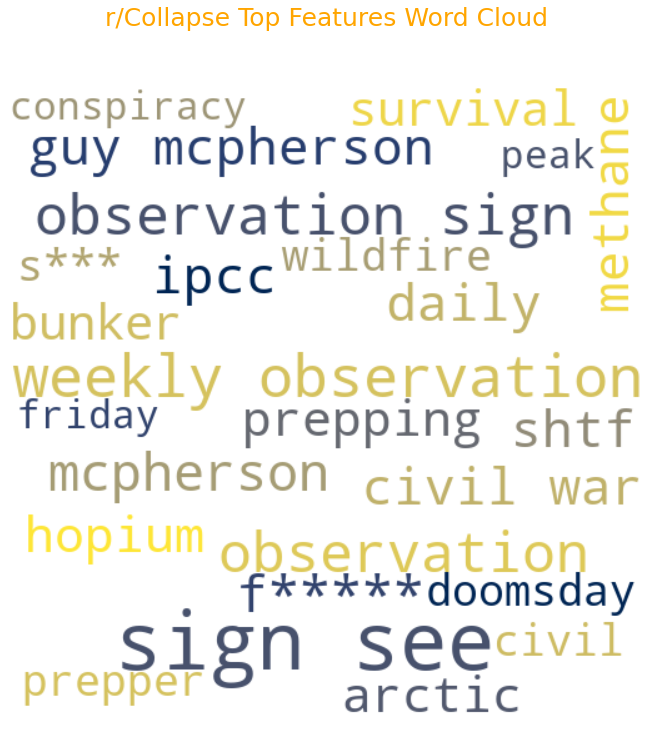

<Figure size 432x288 with 0 Axes>

In [222]:
col_25 = nb_feat_imp2.sort_values(by='feature imps').tail(25).sort_values(by='feature imps',ascending=False)
col_25.rename(index={'fucked':'f*****','shit':'s***','shitpost':'s***post'},inplace=True)
col25_dict = dict(zip(col_25.index.tolist(), abs(col_25['feature imps']).tolist()))

word_cloud = WordCloud(width = 512, height = 512, background_color='white',colormap='cividis').generate_from_frequencies(col25_dict)
plt.figure(figsize=(20,10),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('r/Collapse Top Features Word Cloud\n\n',fontsize=25,color='orange')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
plt.savefig('./images/colwc.png');

### Running Model on the holdout set

https://vitalflux.com/hold-out-method-for-training-machine-learning-model/

In [45]:
y_holdout.value_counts(normalize=True)

collapse      0.503341
Futurology    0.496659
Name: subreddit, dtype: float64

The above shows the baseline rate for the holdout set. To be successful, the model will need to achieve an accuracy rate of higher than 50.3%, such that it performs better than choosing 'collapse' for each status.

In [46]:
y_holdout_le = le.transform(y_holdout)

In [47]:
pipenb4.fit(X_train2,y_train_le2)
pipenb4.score(X_holdout,y_holdout_le)

0.8167143972923718

The model performs with 82% accuracy on the holdout set, which exceeds baseline rate of 50%. This model meets the intended goal of performing better than the baseline.

### Analysis of Results

### Confusion Matrix

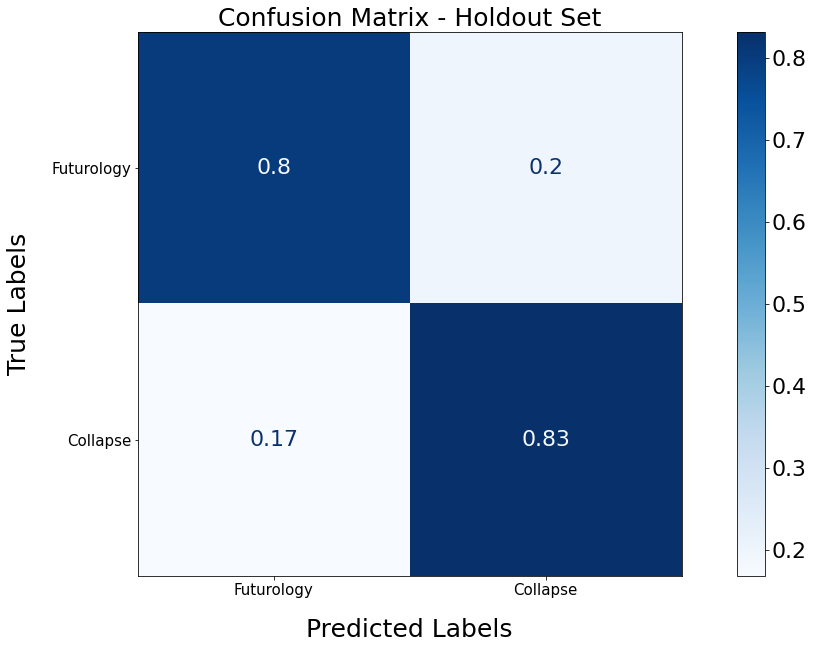

In [48]:
f = plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
ax = plt.subplot()
ConfusionMatrixDisplay.from_estimator(pipenb4,X_holdout,y_holdout_le,cmap='Blues',ax=ax,normalize='true')
ax.set_xlabel('Predicted Labels',labelpad=20,fontsize=25)
ax.set_ylabel('True Labels',labelpad=20,fontsize=25)
ax.set_title('Confusion Matrix - Holdout Set',fontsize=25)
ax.xaxis.set_ticklabels(['Futurology', 'Collapse'],fontsize=15)
ax.yaxis.set_ticklabels(['Futurology', 'Collapse'],fontsize=15)
plt.savefig('./images/confmatrix.png');

Above is the confusion matrix for the holdout set. Since accuracy is the only metric we care about, the important stastics are the proprtion of times the model predicts each classification out of the total number of times the class appears in our holdout data.

Model achieves a better rate predicting Collapse than Futurology:
Futurology Misclassification: 20% / Collapse Misclassification: 17%


### Misclassification DataFrame (via Holdout Set)

Creating a datframe for title in the holdout set that the model incorrectly predicted for further analysis.

In [142]:
test_preds = pipenb4.predict(X_holdout)
misclass = X_holdout.copy()
misclass = pd.DataFrame(misclass,columns=['title'])


misclass['true_class'] = y_holdout
misclass['pred_class'] = ['collapse' if i == 1 else 'Futurology' for i in test_preds]
misclassified = misclass[misclass['true_class'] != misclass['pred_class']]



In [188]:
misclassified.head()

,title,true_class,pred_class
5656,Hospitality of the Future - long post alert,Futurology,collapse
19857,How do you think society is going to change in the 100 years?,Futurology,collapse
13105,"45 out of the 51 busiest train stations in the world are located in Japan, and half of them in the Tokyo area alone",Futurology,collapse
23315,The OGs,collapse,Futurology
11373,Who would you rather have win?,collapse,Futurology


### Analyzing Length of Post

In [491]:
misclassified['title_length'] = [len(i) for i in misclassified['title']]
df_holdout['title_length'] = [len(i) for i in df_holdout['title']]

print(misclassified['title_length'].median(),df_holdout['title_length'].median())
misclassified['title_length'].mean(),df_holdout['title_length'].mean()

50.0 56.0


(62.789373814041745, 68.07107524082271)

The misclassified posts are shorter on average, and have a lower median size post than the average for the holdout set.

### Reviewing the TF-IFD Vectorized Data for Misclassification DataFrame

In [103]:
misct = misclassified['title']

In [108]:
tfmisc = TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 2),tokenizer=lemma_tokenizer,min_df=3)
misc_tf = tfmisc.fit_transform(misct)
misc_tf = pd.DataFrame(misc_tf.A,columns=tfmisc.get_feature_names_out())

In [109]:
misc_tf.sum().sort_values(ascending=False).head(50)

world             34.341812
think             26.943313
change            22.313082
people            22.056505
''                20.123600
need              19.151521
climate           18.068172
human             17.287225
time              16.945343
life              16.278880
good              15.809421
know              15.264371
best              14.991355
idea              14.508312
question          14.392093
help              14.354422
technology        13.896093
next              13.861195
see               13.646358
society           13.418638
look              13.319104
civilization      12.239288
job               12.238976
end               12.216736
which             11.653080
energy            11.386918
sub               11.231683
way               11.169821
want              11.106797
going             10.977852
system            10.969276
go                10.808787
climate change    10.734587
power             10.609110
being             10.285557
humanity          10

The words that show up most frequently in the misclassifcation, when analyzed using standard stopwords library, are the words that were included in our stopwords to keep from giving the model an advantage: future, collapse, futurology.

When toggled to include my custom list of stopwords, 'climate', 'change' and 'climate change' are seen frequently. This could contribute to the more frequent misclassifcation of Futurology, as the model predicts many posts concerning climate change to be from collapse, so discussion around the subject do occur on Futurology, despite the rosier nature of the community.

## Further Research

### Analysis Using SelfText and Title

I quickly analyzed how the model would perform if the available self-text was included in the analysis. Ran model without much additional tuning, adjusted to include trigrams, and allow for 80,000 features. Went through same process of splitting data into train, validation, and holdout sets. For quick study, the null values were replaced as blank text.

In [229]:
pipenb5 = Pipeline(
    [
    ('tfi',TfidfVectorizer(stop_words=my_stop_words,strip_accents='unicode',ngram_range=(1, 3),tokenizer=lemma_tokenizer,max_features=80000)),
    ('nb',MultinomialNB())   
    ])

In [282]:
df_fut_cut2 = df_fut[['selftext','subreddit','title']]
df_col_cut2 = df_col[['selftext','subreddit','title']]
df_comb2 = pd.concat([df_col_cut2,df_fut_cut2])
df_comb2['selftext'] = df_comb2['selftext'].replace('[removed]',' ')                                                
df_comb2['alltext'] = df_comb2['selftext'] + df_comb2['title']
df_comb2 = df_comb2.drop(columns=['selftext','title'])
df_comb2 = df_comb2.sample(frac=1,random_state=2)
df_comb2 = df_comb2.dropna()
df_comb2 = df_comb2.drop_duplicates()
df_holdout2 = df_comb2[0:10662]
df_main2 = df_comb2[10662:]

X3 = df_main2['alltext']
y3 = df_main2['subreddit']



In [283]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,y3,random_state=2,stratify=y3)

y_train_le3 = le.fit_transform(y_train3)
y_test_le3 = le.transform(y_test3)

In [284]:
y_test3.value_counts(normalize=True)

collapse      0.512662
Futurology    0.487338
Name: subreddit, dtype: float64

Generated baseline of 51.26% for comparison.

In [285]:
pipenb5.fit(X_train3,y_train_le3)
pipenb5.score(X_train3,y_train_le3),pipenb5.score(X_test3,y_test_le3)

(0.902235422854463, 0.8464640780341399)

The model performed with 84.64% accuracy on the validation set.

In [286]:
X_hold2 = df_holdout2['alltext']
y_hold2 = df_holdout2['subreddit']
y_hold2_le = le.transform(y_hold2)

pipenb5.score(X_hold2,y_hold2_le)

0.8504033014443819

The model similarly scored 85% accuracy on the holdout set.

The next steps in improving then model would be to further explore how well the model might perform if we fine-tune it using this additional data. More precision would have to be applied to how the null values are addressed.

### Model's Probability Calculation for Inclusion in Presenation - Title/Holdout

In [213]:
pipenb4.predict_proba(misclassified.loc[[7447]])

array([[0.62241583, 0.37758417],
       [0.50228522, 0.49771478],
       [0.50228522, 0.49771478]])

In [214]:
pipenb4.predict_proba(misclassified.loc[3701])

array([[0.90642234, 0.09357766],
       [0.50228522, 0.49771478],
       [0.95340096, 0.04659904]])

In [179]:
pipenb4.predict_proba(misclassified.loc[7138])

array([[0.70133966, 0.29866034],
       [0.50228522, 0.49771478],
       [0.95340096, 0.04659904]])

In [181]:
pipenb4.predict_proba(misclassified.loc[26113])

array([[0.45785894, 0.54214106],
       [0.95340096, 0.04659904],
       [0.50228522, 0.49771478]])

In [182]:
pipenb4.predict_proba(misclassified.loc[18386])

array([[0.30763275, 0.69236725],
       [0.95340096, 0.04659904],
       [0.50228522, 0.49771478]])

In [189]:
pipenb4.predict_proba(misclassified.loc[9741])

array([[0.03361823, 0.96638177],
       [0.95340096, 0.04659904],
       [0.50228522, 0.49771478]])

In [183]:
nb_feat_imp2.loc[['autonomous','weapon','un','automation','explosion','usa','vehicle','social','population growth',\
                 'global population','vertical farming','machine','huge','noticed','owns','pacific','atlantic','atlantic ocean',\
                 'life','outer space','space','save','disruption','classified','happening','take','bridge','build','worse','hope','brings',\
                  'apocalyptic']]

,feature imps
autonomous,-2.793291
weapon,-0.306460
un,0.675385
automation,-2.393882
explosion,0.470907
usa,1.575752
vehicle,-1.789149
social,-0.318732
population growth,-0.474787
global population,1.514335
